In [1]:
!pip install -q gdown

import os

In [2]:
file_id ="14M7ANbXL5eWkKdmPNgHWqvKGCHNlPp-V"
file_name = "Concrete_Cracks.zip"
target_folder = "unziped_concrete"

if not os.path.exists(file_name):
    !gdown --id {file_id} -O {file_name}
else:
    print("Zip dosyası zaten mevcut,indirilmedi")

if not os.path.exists(target_folder):
    print(f"'{target_folder}' oluşturuluyor ve zip dosyası içine açılıyor...")
    !mkdir -p "{target_folder}"
    !unzip -q -n "{file_name}" -d "{target_folder}"
    print("İşlem tamamlandı.")
else:
    print(f"'{target_folder}'zaten mevut zip açılmadı.")
# https://drive.google.com/file/d/14M7ANbXL5eWkKdmPNgHWqvKGCHNlPp-V/view?usp=drive_link

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=14M7ANbXL5eWkKdmPNgHWqvKGCHNlPp-V
From (redirected): https://drive.google.com/uc?id=14M7ANbXL5eWkKdmPNgHWqvKGCHNlPp-V&confirm=t&uuid=6911ae1b-ef71-466c-b17f-588642e6bf4d
To: /kaggle/working/Concrete_Cracks.zip
100%|████████████████████████████████████████| 244M/244M [00:03<00:00, 78.1MB/s]
'unziped_concrete' oluşturuluyor ve zip dosyası içine açılıyor...
İşlem tamamlandı.


In [5]:
import shutil
import random


main_dir = target_folder 


yeni_klasor_tabani = "veri_seti_split"

split_orani = 0.8  


print("İşlem başlıyor...")

kaynak_positive_dir = os.path.join(main_dir, "Positive")
kaynak_negative_dir = os.path.join(main_dir, "Negative")

train_dir = os.path.join(yeni_klasor_tabani, "train")
train_positive_dir = os.path.join(train_dir, "Positive")
train_negative_dir = os.path.join(train_dir, "Negative")

validation_dir = os.path.join(yeni_klasor_tabani, "validation")
validation_positive_dir = os.path.join(validation_dir, "Positive")
validation_negative_dir = os.path.join(validation_dir, "Negative")

os.makedirs(train_positive_dir, exist_ok=True)
os.makedirs(train_negative_dir, exist_ok=True)
os.makedirs(validation_positive_dir, exist_ok=True)
os.makedirs(validation_negative_dir, exist_ok=True)

print("Hedef klasörler oluşturuldu veya zaten mevcut.")

def split_and_copy_files(source_path, train_path, validation_path, ratio):

    files = os.listdir(source_path)
    
    random.shuffle(files)
    
    split_point = int(len(files) * ratio)
    
    train_files = files[:split_point]
    validation_files = files[split_point:]
    
    for file in train_files:
        shutil.copyfile(os.path.join(source_path, file), os.path.join(train_path, file))
        
    for file in validation_files:
        shutil.copyfile(os.path.join(source_path, file), os.path.join(validation_path, file))

print("Positive sınıfı dosyaları ayrılıyor...")
split_and_copy_files(kaynak_positive_dir, train_positive_dir, validation_positive_dir, split_orani)

print("Negative sınıfı dosyaları ayrılıyor...")
split_and_copy_files(kaynak_negative_dir, train_negative_dir, validation_negative_dir, split_orani)



print("\n--- İŞLEM TAMAMLANDI ---")
print("Dosya sayıları kontrol ediliyor:")
print(f"Eğitim (Positive):   {len(os.listdir(train_positive_dir))} dosya")
print(f"Eğitim (Negative):   {len(os.listdir(train_negative_dir))} dosya")
print(f"Validasyon (Positive): {len(os.listdir(validation_positive_dir))} dosya")
print(f"Validasyon (Negative): {len(os.listdir(validation_negative_dir))} dosya")

İşlem başlıyor...
Hedef klasörler oluşturuldu veya zaten mevcut.
Positive sınıfı dosyaları ayrılıyor...
Negative sınıfı dosyaları ayrılıyor...

--- İŞLEM TAMAMLANDI ---
Dosya sayıları kontrol ediliyor:
Eğitim (Positive):   16000 dosya
Eğitim (Negative):   16000 dosya
Validasyon (Positive): 4000 dosya
Validasyon (Negative): 4000 dosya


In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_SIZE = (160, 160)  
BATCH_SIZE = 32      

train_dir = "veri_seti_split/train"
validation_dir = "veri_seti_split/validation"

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,         
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=False,        
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 32000 files belonging to 2 classes.


I0000 00:00:1754471557.199419      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 8000 files belonging to 2 classes.


In [8]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'  
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15


I0000 00:00:1754471671.048963     136 service.cc:148] XLA service 0x7ec5140025d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754471671.049793     136 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754471671.999796     136 cuda_dnn.cc:529] Loaded cuDNN version 90300


   7/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.4877 - loss: 0.8720 

I0000 00:00:1754471675.614174     136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.8383 - loss: 0.3699 - val_accuracy: 0.9835 - val_loss: 0.0742
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9776 - loss: 0.0799 - val_accuracy: 0.9866 - val_loss: 0.0507
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9825 - loss: 0.0581 - val_accuracy: 0.9880 - val_loss: 0.0419
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9847 - loss: 0.0483 - val_accuracy: 0.9886 - val_loss: 0.0369
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9867 - loss: 0.0428 - val_accuracy: 0.9895 - val_loss: 0.0336
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9878 - loss: 0.0394 - val_accuracy: 0.9905 - val_loss: 0.0314
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9885 - loss: 0.0361 - val_accuracy: 0.9906 - val_loss: 0.0299
Epoch 8/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9890 - loss: 0.03

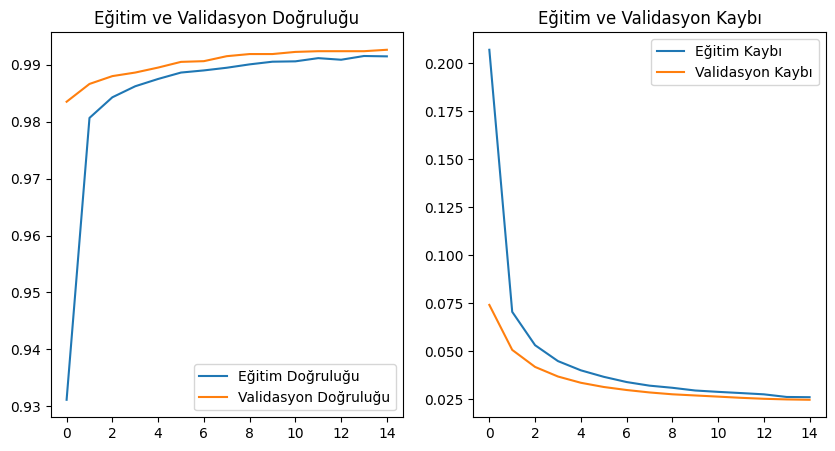

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=['accuracy']  
)

EPOCHS = 15  
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Eğitim Doğruluğu')
plt.plot(range(EPOCHS), val_acc, label='Validasyon Doğruluğu')
plt.legend(loc='lower right')
plt.title('Eğitim ve Validasyon Doğruluğu')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Eğitim Kaybı')
plt.plot(range(EPOCHS), val_loss, label='Validasyon Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Validasyon Kaybı')
plt.show()

In [14]:
model.save('Concrete_Cracks_99.keras')